# Classical Shadows

## System

- H2 3-21G
- 8 qubits system with JW encoding

In [20]:
from tangelo.molecule_library import mol_H2_321g
from tangelo.toolboxes.ansatz_generator.qcc import QCC
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

mol = mol_H2_321g

ferm_ham = mol.fermionic_hamiltonian

encoding = "JW"
up_then_down = True
n_spinorbs = mol.n_active_sos
n_elecs = mol.n_active_electrons

qubit_ham = fermion_to_qubit_mapping(ferm_ham, encoding, n_spinorbitals=n_spinorbs, n_electrons=n_elecs, up_then_down=up_then_down)
print(len(qubit_ham.terms))
print(qubit_ham)

185
(2.5799490123759825+0j) [] +
(0.0165948608377951+0j) [X0 X1 X2 X3] +
(0.0039460152385773165+0j) [X0 X1 Y2 Y3] +
(0.02228270026844538+0j) [X0 X1 X4 X5] +
(0.020025172578589597+0j) [X0 X1 X4 Z5 Z6 X7] +
(0.02228270026844538+0j) [X0 X1 Y4 Y5] +
(0.020025172578589597+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.004162288539263878+0j) [X0 X1 X5 X6] +
(-0.004162288539263878+0j) [X0 X1 Y5 Y6] +
(0.023349354365647793+0j) [X0 X1 X6 X7] +
(0.023349354365647793+0j) [X0 X1 Y6 Y7] +
(0.012648845599217778+0j) [X0 Y1 Y2 X3] +
(0.09380376299959207+0j) [X0 Z1 X2] +
(-0.019407185413048596+0j) [X0 Z1 X2 Z3] +
(0.028545460511678968+0j) [X0 Z1 X2 X4 Z5 X6] +
(0.028545460511678968+0j) [X0 Z1 X2 Y4 Z5 Y6] +
(-0.04160969890900229+0j) [X0 Z1 X2 Z4] +
(0.019403339127070474+0j) [X0 Z1 X2 X5 Z6 X7] +
(0.019403339127070474+0j) [X0 Z1 X2 Y5 Z6 Y7] +
(-0.013922606768505496+0j) [X0 Z1 X2 Z5] +
(-0.033174242346539075+0j) [X0 Z1 X2 Z6] +
(-0.05082457487428466+0j) [X0 Z1 X2 Z7] +
(0.020025172578589597+0j) [X0 Z1 Z2 X3 X4 X5] +
(0.

- Introduce the QCC circuit

In [2]:
ansatz = QCC(mol, mapping=encoding, up_then_down=up_then_down)
ansatz.build_circuit()

- Minimizing classical parameters with VQESolver
- Extracting the optimized circuit

In [3]:
from tangelo.algorithms.variational import VQESolver

vqe = VQESolver({"qubit_hamiltonian": qubit_ham, "ansatz": ansatz.circuit})
vqe.build()
energy_ref = vqe.simulate()
print(f"Energy from statevector simulation: {energy_ref:.4f} hartree")

Energy from statevector simulation: -1.1473 hartree


## Visualization

- Visualization of the circuit with the qiskit module

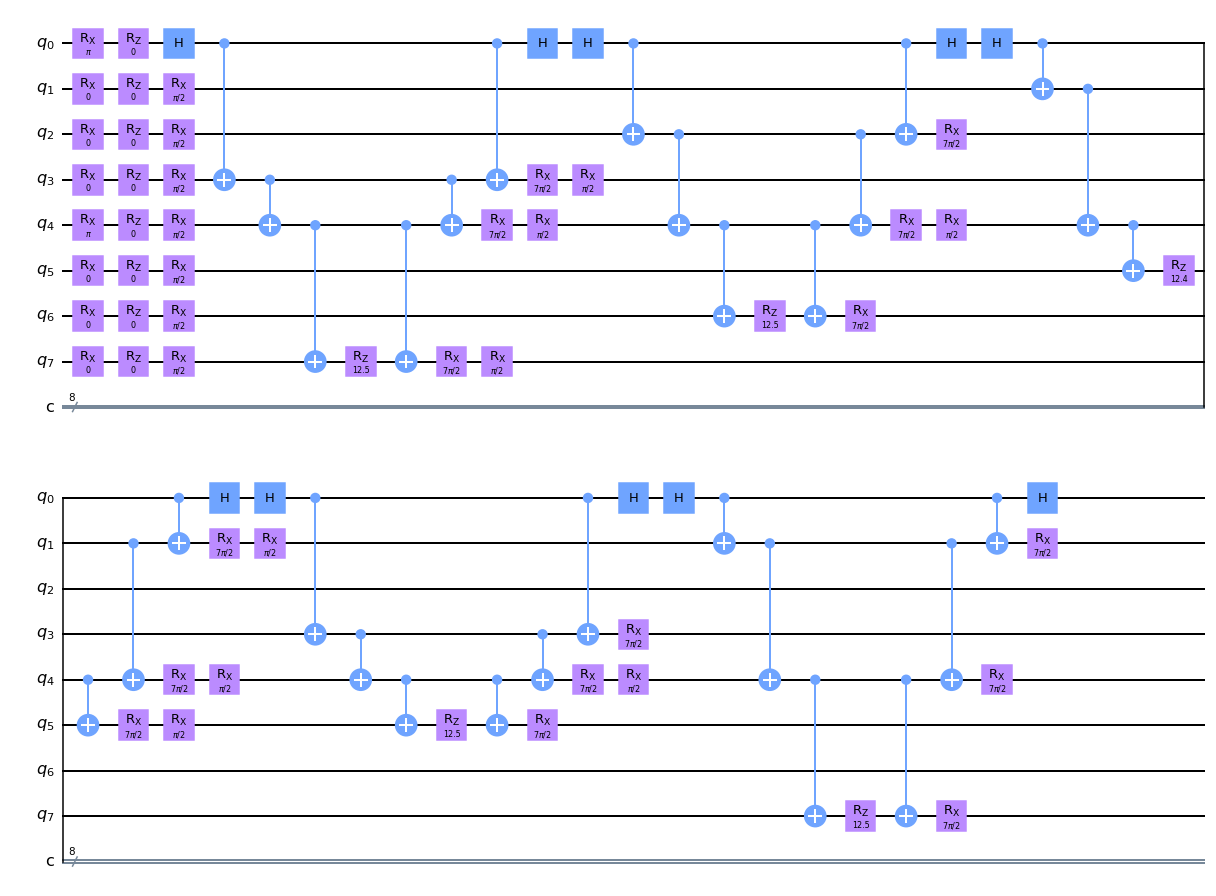

In [4]:
from tangelo.linq.translator import translate_qiskit

qiskit_circuit = translate_qiskit(vqe.optimal_circuit)
qiskit_circuit.draw(output="mpl")

## Measurement budget

- Talk about measurement budget = number of shots
- Number of shots vs accuracy
- Refer to Tangelo function for estimating the cost on real hardware

In [5]:
from tangelo.linq.qpu_connection import job_estimate

n_shots_budget = 1000

cost = job_estimate(vqe.optimal_circuit, n_shots_budget)
print(f"{n_shots_budget} shots through Braket IonQ: {cost['braket_ionq']:.2f}$ US")
print(f"{n_shots_budget} shots through Braket Rigetti: {cost['braket_rigetti']:.2f}$ US")

qemist_client python package not found (optional dependency for hardware experiment submission)
1000 shots through Braket IonQ: 10.30$ US
1000 shots through Braket Rigetti: 0.65$ US


## Reference values

- Without Noise, tell how it should be easy to test
- Equally distributed (easiest method)
- Research is done to allocate number of measurements depending of the coefficients / variances in a qubit Hamiltonian
- We provide qubit-wise commutativity at the time of writing this notebook

In [6]:
from tangelo.linq import Simulator
from tangelo.toolboxes.operators import QubitOperator

n_shots_per_term = round(n_shots_budget / len(qubit_ham.terms))
shots_backend = Simulator("cirq", n_shots=n_shots_per_term, noise_model=None)
print(f"{n_shots_per_term} shots per term when equally distributed.")

for _ in range(10):
    energy_shots = 0.
    for term, coeff in qubit_ham.terms.items():
        qubit_term = QubitOperator(term, coeff)    
        energy_shots += shots_backend.get_expectation_value(qubit_term, vqe.optimal_circuit)

    #print(f"Energy from equally distributed shots simulation: {energy_shots:.4f} hartree")
    print(f"Error vs statevector simulation: {abs(energy_ref-energy_shots):.3f} hartree")

5 shots per term when equally distributed.
Error vs statevector simulation: 0.173 hartree
Error vs statevector simulation: 0.070 hartree
Error vs statevector simulation: 0.055 hartree
Error vs statevector simulation: 0.025 hartree
Error vs statevector simulation: 0.046 hartree
Error vs statevector simulation: 0.107 hartree
Error vs statevector simulation: 0.151 hartree
Error vs statevector simulation: 0.135 hartree
Error vs statevector simulation: 0.356 hartree
Error vs statevector simulation: 0.080 hartree


## Classical Shadows

- Talk about defining the backend (without or with noise)
- Tell about the warning if n_shots =/= 1 (explain the process behind)

In [7]:
cs_backend = Simulator("cirq", n_shots=1, noise_model=None)

## Randomized Single-Pauli Classical Shadows

- Summarize procedure of random sampling.

In [8]:
from tangelo.toolboxes.measurements import RandomizedClassicalShadow

for _ in range(10):
    random_cs = RandomizedClassicalShadow(vqe.optimal_circuit)
    random_cs.build(n_shots_budget)
    random_cs.simulate(cs_backend)

    energy_random = random_cs.get_observable(qubit_ham)
    #print(f"Energy from randomized single-Pauli classical shadow: {energy_random:.4f} hartree")
    print(f"Error vs statevector simulation: {abs(energy_ref-energy_random):.3f} hartree")

Error vs statevector simulation: 0.010 hartree
Error vs statevector simulation: 0.261 hartree
Error vs statevector simulation: 0.112 hartree
Error vs statevector simulation: 0.025 hartree
Error vs statevector simulation: 0.154 hartree
Error vs statevector simulation: 0.041 hartree
Error vs statevector simulation: 0.051 hartree
Error vs statevector simulation: 0.085 hartree
Error vs statevector simulation: 0.149 hartree
Error vs statevector simulation: 0.056 hartree


## Derandomized Single-Pauli Classical Shadows

- Summarize procedure of derandom sampling.

In [9]:
from tangelo.toolboxes.measurements import DerandomizedClassicalShadow

for _ in range(10):
    derandom_cs = DerandomizedClassicalShadow(vqe.optimal_circuit)
    derandom_cs.build(n_shots_budget, qubit_ham)
    derandom_cs.simulate(cs_backend)

    energy_derandom = derandom_cs.get_observable(qubit_ham)
    #print(f"Energy from derandomized single-Pauli classical shadow: {energy_derandom:.4f} hartree")
    print(f"Error vs statevector simulation: {abs(energy_ref-energy_derandom):.3f} hartree")

Error vs statevector simulation: 0.021 hartree
Error vs statevector simulation: 0.034 hartree
Error vs statevector simulation: 0.104 hartree
Error vs statevector simulation: 0.061 hartree
Error vs statevector simulation: 0.050 hartree
Error vs statevector simulation: 0.105 hartree
Error vs statevector simulation: 0.040 hartree
Error vs statevector simulation: 0.102 hartree
Error vs statevector simulation: 0.049 hartree
Error vs statevector simulation: 0.030 hartree


## Adaptive Single-Pauli Classical Shadows

- Summarize procedure of adaptive sampling.

In [10]:
from tangelo.toolboxes.measurements import AdaptiveClassicalShadow

for _ in range(10):
    adaptive_cs = AdaptiveClassicalShadow(vqe.optimal_circuit)
    adaptive_cs.build(n_shots_budget, qubit_ham)
    adaptive_cs.simulate(cs_backend)

    energy_adaptive = adaptive_cs.get_observable(qubit_ham)
    #print(f"Energy from adaptive single-Pauli classical shadow: {energy_adaptive:.4f} hartree")
    print(f"Error vs statevector simulation: {abs(energy_ref-energy_adaptive):.3f} hartree")

/home/alex/Codes/Tangelo/tangelo/toolboxes/measurements/classical_shadows/adaptive.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  cbs = {basis: sqrt(cb) for basis, cb in cbs.items()}


Error vs statevector simulation: 0.062 hartree
Error vs statevector simulation: 0.029 hartree
Error vs statevector simulation: 0.042 hartree
Error vs statevector simulation: 0.141 hartree
Error vs statevector simulation: 0.107 hartree
Error vs statevector simulation: 0.044 hartree
Error vs statevector simulation: 0.132 hartree
Error vs statevector simulation: 0.200 hartree
Error vs statevector simulation: 0.148 hartree
Error vs statevector simulation: 0.218 hartree


In [24]:
random_cs = RandomizedClassicalShadow(vqe.optimal_circuit)
random_cs.build(n_shots_budget)
print(len(random_cs.unique_unitaries))
print(random_cs.unique_unitaries)

914
['ZXXZXZYZ', 'XZZZXYZZ', 'ZZZYYYYY', 'YZZXZXZY', 'YXXXYYZZ', 'XZZYXXXY', 'XXZXZYYY', 'YZYZZXZY', 'YZXXXXZX', 'ZZYYYZYZ', 'XXXZXXYX', 'XXYYYYYY', 'XXXXXZZY', 'YYXYYZYY', 'YXZYXZZZ', 'XXZXZXXY', 'ZYYXZXZX', 'ZXYXZZZZ', 'XZXXYZZY', 'XYYZZXXY', 'ZYZZZYYZ', 'YZZYXXZY', 'XXYYXZZX', 'XXYXZZZZ', 'ZXZXXZZX', 'YZYYZZYX', 'ZZYXZZYY', 'ZYZYZZYZ', 'XYZZXYXY', 'XZZXXZZZ', 'XXXZYZYY', 'YYXXYZXY', 'YZXXZYXZ', 'YXXXXZYZ', 'XXYYYZZZ', 'ZXYYXYXY', 'YXZXYYXY', 'YZZYZZYX', 'XZXXXXZY', 'XXYZZZXZ', 'ZXXZZYXZ', 'XZZXYXZY', 'XZXZXXZY', 'XXYYXZXX', 'ZXYZZYXY', 'XYYXYXYY', 'ZXZXYYXY', 'XZXYYZXY', 'ZXZYXYYX', 'YYZYYXYY', 'XXXYXZZX', 'YZZZXXZX', 'YXYZXYYZ', 'XYYXXXXZ', 'YYXYXZZY', 'ZXYYZXYZ', 'YZXYZXYZ', 'ZYXXYXZX', 'YYZXZZXZ', 'ZYZXXYYX', 'XYXYXXZZ', 'XXZZXZYZ', 'ZYXYYXXZ', 'YYZZXXYX', 'YZZXZYYX', 'YYYXXYZX', 'ZYXXYZYY', 'XYZZXYYX', 'ZYYYYZYY', 'XYZXXXYZ', 'XXYZYXZX', 'ZYYYYZXX', 'ZZYYYYXX', 'ZXYXXYYZ', 'ZYXXZXYY', 'YXYYYYYX', 'XZYYZZXY', 'XZYYYZZX', 'YXXZXYZZ', 'YZYZXZXZ', 'ZZXZZXZY', 'XXXZYYYY', 'ZXXZYYZY',

In [25]:
derandom_cs = DerandomizedClassicalShadow(vqe.optimal_circuit)
derandom_cs.build(n_shots_budget, qubit_ham)
print(len(derandom_cs.unique_unitaries))
print(derandom_cs.unique_unitaries)

60
['YZYYXZXX', 'YZZYYYYY', 'XZXXXZXX', 'YZYYZZXX', 'ZXZXXZXZ', 'ZZYZZZZZ', 'YZYYYZYY', 'XYZYZZZZ', 'XZZZZYZY', 'ZZYYXZZX', 'XZXZXZXZ', 'ZZZZZXZX', 'YYZYYZZY', 'XXZXYYZY', 'XZXXZXZX', 'XZXXYZZY', 'XXXXXXXX', 'YYZYXZZX', 'YZZYZZXX', 'XZXXYYZY', 'YZYYZYZY', 'XXZXYZYY', 'ZZZZZYZY', 'YZYYXXZX', 'YYYYYYYY', 'ZZZZXZXZ', 'ZZXXYZZY', 'YZZYXZZX', 'ZYZYZYZY', 'ZZZZYZYZ', 'XZXXYZYZ', 'ZZZZZZZZ', 'XZZXXXXX', 'YZYZYZYZ', 'XXYYYZZY', 'ZZXZZXZX', 'YZYZZZZZ', 'XZZXXZZX', 'XZZXYZZY', 'ZXZXZZZZ', 'ZYZYYZYZ', 'YYZYXXZX', 'ZZXXYZYY', 'XZXZZZZZ', 'YZZYXXXX', 'XZZXZZXX', 'XZXZYZYZ', 'ZXZXZXZX', 'YZZYYZZY', 'YYZYXZXX', 'XZXXZZYY', 'XZZXZZYY', 'ZZXZZZZZ', 'ZZYYYZZY', 'YZZYZZYY', 'XXXZXZZX', 'YZYYXZXZ', 'ZYZYZZZZ', 'XZZXYYYY', 'ZZXXXZZX']


In [26]:
adaptive_cs = AdaptiveClassicalShadow(vqe.optimal_circuit)
adaptive_cs.build(n_shots_budget, qubit_ham)
print(len(adaptive_cs.unique_unitaries))
print(adaptive_cs.unique_unitaries)

925
['XXYXXZZY', 'XYXYYXYX', 'XZZZXYZZ', 'YYYZXYYX', 'YXZZXYZY', 'ZYZZZZXY', 'YYXXXYYY', 'ZXXZZZXY', 'XZZYZXYX', 'XYYXZYYX', 'YYZYYZYY', 'ZYYXZXZX', 'XXZXZXXY', 'YZXYZYZZ', 'XYXZYXZZ', 'ZXZYXXXX', 'YYYZXYZY', 'XXYYXZZX', 'YZXZZZZY', 'XZZZYXXZ', 'ZXYYXYZY', 'YXZZXYYX', 'ZYZYZXYX', 'XYZZXYXY', 'ZXYZZZXY', 'YXXZXXZZ', 'XYZXZYYX', 'XXYYZXZZ', 'YZZYZZYX', 'ZZZXZYZZ', 'ZXXZZYXZ', 'ZZXZZYZY', 'YXZZYZZY', 'YZYZXYZX', 'YZXZZYYZ', 'XZXZZXYY', 'ZZXXXZYX', 'XYXYYYZY', 'XYZZYZXY', 'ZXZYXYYX', 'XYXZYYYX', 'XYZXZYZZ', 'ZYXXYXZX', 'ZYZYXZXX', 'ZXXZXZXZ', 'YYZZXXZX', 'YZYYXXZZ', 'XXYYXYXZ', 'XXZYZYYX', 'XXYZZXZY', 'ZXXXYXZZ', 'YYZYZZZX', 'XYYYYXXZ', 'ZYYYYZYY', 'XXZYZZXY', 'YXZZYYYX', 'ZYYXXXYY', 'ZXYYZZXX', 'YYXYZYYY', 'ZZYYYYXX', 'XXZYYXXX', 'ZYXZZYZZ', 'YXYYXZZZ', 'ZZXZXZZX', 'YXXXYYZY', 'YZXYXZXZ', 'XXZZZYXY', 'YXXYZXXY', 'ZXZZXYXX', 'XYYZZZXZ', 'ZZXXZXYZ', 'XXZZXXYX', 'ZZXYZXZY', 'YYYXZZXX', 'ZZXZYXYX', 'XZZYXYXX', 'YXXZZZXY', 'YZZXXZYZ', 'ZXZYYYZZ', 'ZZXZYYYX', 'ZXXZYZYZ', 'YZYYZYZY', 'XYYXYZXX',